In [4]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet
import random
import time

### Load data

In [5]:
!wget --random-wait -i ../data/georges.csv -P ../data/images/georges
!wget --random-wait -i ../data/non_georges.csv -P ../data/images/non_georges

#### Remove dublicates

In [6]:
!rm ../data/images/*/*.1
!rm ../data/images/*/*.2
!rm ../data/images/*/*.3

#### Visualize a few images

In [ ]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = '../data/images/georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ('Image' + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [ ]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = '../data/images/non_georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ('Image' + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

### Define training parameters

In [9]:
eff_models = ['efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2',
          'efficientnet-b3', 'efficientnet-b4']
eff_batch_sizes = [150, 100, 64, 50, 20]
eff_image_sizes = [224, 240, 260, 300, 380]
model_index = 2

params = {
    'model': eff_models[model_index],
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'lr': 0.00005,
    'batch_size': eff_batch_sizes[model_index],
    'num_workers': 4,
    'num_epochs': 12,
    'train_size': 0.7,
    'num_classes': 2,
    'input_size': eff_image_sizes[model_index]
}

Take care of reproducibility

In [10]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Define and initialize model

Pretrained Efficintnet-b2.



In [11]:
model = EfficientNet.from_pretrained(params['model'])

Loaded pretrained weights for efficientnet-b2


In [12]:
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, params['num_classes'])

for param in model.parameters():
    param.require_grad = True

model = model.to(params['device'])

In [ ]:
print(model)

### Setup transforms, datasets, and dataloaders

In [14]:
class GeorgeVsNonGeorgeDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == 'georges':
            label = 1
        else:
            label = 0
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label

In [15]:
root_directory = '../data/images'

geo_directory = os.path.join(root_directory, 'georges')
nongeo_directory = os.path.join(root_directory, 'non_georges')

geo_images_paths = sorted([os.path.join(geo_directory, f) for f in os.listdir(geo_directory)])
nongeo_images_paths = sorted([os.path.join(nongeo_directory, f) for f in os.listdir(nongeo_directory)])
images_paths = [*geo_images_paths, *nongeo_images_paths]

num_imgs = len(images_paths)
indices = list(range(num_imgs))
class_names = ['non_georges', 'georges']

np.random.shuffle(images_paths)

split = int(params['train_size'] * num_imgs)
split2 = int((split + num_imgs) / 2)
train_paths, val_paths, test_paths = images_paths[:split], images_paths[split:split2], images_paths[split2:]

In [ ]:
train_trans = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.Blur(p=0.3),
        A.Cutout(8, p=0.3),
        A.SmallestMaxSize(max_size=params['input_size'] + 5),
        A.RandomCrop(height=params['input_size'], width=params['input_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

val_trans = A.Compose(
    [
        A.SmallestMaxSize(max_size=params['input_size'] + 5),
        A.CenterCrop(height=params['input_size'], width=params['input_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

train_data = GeorgeVsNonGeorgeDataset(images_filepaths=train_paths, transform=train_trans)
val_data = GeorgeVsNonGeorgeDataset(images_filepaths=val_paths, transform=val_trans)
test_data = GeorgeVsNonGeorgeDataset(images_filepaths=test_paths, transform=val_trans)

dataloaders_dict = {'train' : DataLoader(
    train_data, batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers']
),
                    'val': DataLoader(
    val_data, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers']
),
                    'test': DataLoader(
    test_data, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers']
)
                   }

### Create the optimizer and criterion

In [17]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, cooldown=1)

In [18]:
criterion = nn.CrossEntropyLoss()

### Train and evaluate

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs=10):
    since = time.time()

    history = {
        'train_acc': [],
        'train_loss': [],
        'val_acc': [],
        'val_loss': [],
        'lr': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(params['device'])
                labels = labels.to(params['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            if phase == 'val':
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)
        
        history['lr'].append(get_lr(optimizer))
        lr_scheduler.step(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [20]:
def visualize_images(model, num_images=6):
    mean = np.array([0.485, 0.456, 0.406])
    std =  np.array([0.229, 0.224, 0.225])
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(16, 17))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['test']):
            inputs = inputs.to(params['device'])
            labels = labels.to(params['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, true label: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0)) * std + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
def build_val_curves(hist):
    epochs = np.arange(1, params['num_epochs'] + 1)
    plt.figure(figsize=(25, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist['train_acc'], '-k', label='train')
    plt.plot(epochs, hist['val_acc'], '-r', label='validation')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('model accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist['train_loss'], '-k', label='train')
    plt.plot(epochs, hist['val_loss'], '-r', label='validation')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('model loss')
    plt.title('loss curves')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(epochs, hist['lr'], '-k')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('learing rate')
    plt.title('model learning rate')
    plt.legend()
    

In [21]:
model, hist = train_model(model, dataloaders_dict, criterion, optimizer,
                          scheduler, num_epochs=params['num_epochs']
                         )

Epoch 1/12
----------
train Loss: 0.6129 Acc: 0.6904
val Loss: 0.5348 Acc: 0.7404

Epoch 2/12
----------
train Loss: 0.4270 Acc: 0.8225
val Loss: 0.3337 Acc: 0.8678

Epoch 3/12
----------
train Loss: 0.3146 Acc: 0.8681
val Loss: 0.2471 Acc: 0.9029

Epoch 4/12
----------
train Loss: 0.2578 Acc: 0.9000
val Loss: 0.2046 Acc: 0.9251

Epoch 5/12
----------
train Loss: 0.2214 Acc: 0.9140
val Loss: 0.2034 Acc: 0.9205

Epoch 6/12
----------
train Loss: 0.1984 Acc: 0.9238
val Loss: 0.1892 Acc: 0.9298

Epoch 7/12
----------
train Loss: 0.1721 Acc: 0.9366
val Loss: 0.1767 Acc: 0.9415

Epoch 8/12
----------
train Loss: 0.1479 Acc: 0.9423
val Loss: 0.1722 Acc: 0.9357

Epoch 9/12
----------
train Loss: 0.1382 Acc: 0.9476
val Loss: 0.1735 Acc: 0.9380

Epoch 10/12
----------
train Loss: 0.1177 Acc: 0.9524
val Loss: 0.1689 Acc: 0.9462

Epoch 11/12
----------
train Loss: 0.1096 Acc: 0.9566
val Loss: 0.1870 Acc: 0.9333

Epoch 12/12
----------
train Loss: 0.1039 Acc: 0.9616
val Loss: 0.1883 Acc: 0.9287

T

### Predict labels and visualize curves



In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders_dict['test']:
        inputs, labels = data
        inputs = inputs.to(params['device'])
        labels = labels.to(params['device'])
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total}')

Accuracy of the network on test images: 93.80841121495327


In [ ]:
visualize_images(model, 12)

No handles with labels found to put in legend.


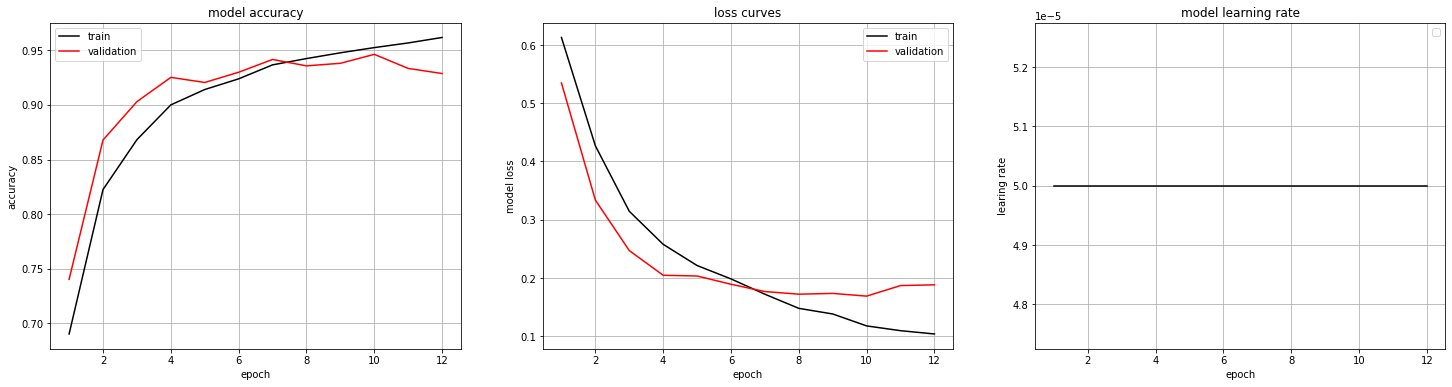

In [26]:
build_val_curves(hist)

In [27]:
torch.save(model.state_dict(), '../models/eff-net-b2-fine-tuning.pt')